## NLP Class Final Project
### Part 2 - EDA, NER & Topic Modeling

Author: Aashish Singh

In [1]:
import os
import time
import math
import re
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string

from collections import Counter
import wordcloud

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import nltk
import spacy

import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
import warnings

warnings.simplefilter('once')
warnings.simplefilter('ignore')
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

/Users/aashishsingh/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/aashishsingh/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aashishsingh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aashishsingh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/aashishsingh/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nl

True

In [2]:
import multiprocessing
from pandarallel import pandarallel
num_processors = multiprocessing.cpu_count()
num_processors
workers = num_processors-1
pandarallel.initialize(nb_workers=multiprocessing.cpu_count()-1, use_memory_fs=False)
print(f'Using {workers} workers')

INFO: Pandarallel will run on 11 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Using 11 workers


In [3]:
import os
import time
import math
start_time = time.time()

def tic():
    global start_time 
    start_time = time.time()

def tac():
    t_sec = round(time.time() - start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print(f'Execution time: {t_hour}hour:{t_min}min:{t_sec}sec'.format(t_hour,t_min,t_sec))

In [4]:
%%time

news_processed = pd.read_parquet('~/Downloads/news_processed.parquet')
news_processed.shape 

CPU times: user 25.8 s, sys: 33 s, total: 58.8 s
Wall time: 49.4 s


(120177, 17)

In [5]:
# # Sample 5% of data to run the notebook (remove during final run)
# news_processed = news_processed.sample(frac=0.10, random_state=123)
# news_processed.shape

In [6]:
news_processed.head(5)

,url,date,language,title,text,year,month,day,text_ner,title_ner,text_cleaned,title_cleaned,text_lemmatized,title_lemmatized,text_tokenized,title_tokenized,text_word_count
0,http://newsparliament.com/2020/02/27/children-with-autism-saw-their-learning-and-social-skills-boosted-after-playing-with-this-ai-robot/,2020-02-27,en,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament,"\nChildren With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament\n \n\nSkip to content\n\t\t\tThursday, February 27, 2020\t\t\n\nLatest:\n\n\nMansplaining in conferences: How can we get him to forestall?\n\n\nDrax power station to cease burning coal in March 2021\n\n\nCoronavirus Could Explode in the U.S. Overnight Like it Did in Italy\n\n\nCoronavirus: Dettol sales surge as markets fall again\n\n\nLevi Strauss marks the next phase in cor...",2020,2,27,"Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot News Parliament Skip to content Thursday, February, Latest Mansplaining in conferences How can we get him to forestall Drax power station to cease burning coal in March Coronavirus Could Explode in the U.S. Overnight Like it Did in Italy Coronavirus Dettol sales surge as markets fall again Levi Strauss marks the next phase in corporate paid leave policies News Parliament Get the Real Story News...",Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot News Parliament,children autism saw learning social skills boosted playing ai robot news parliament skip content thursday february latest mansplaining conferences get forestall drax power station cease burning coal march coronavirus could explode overnight like italy coronavirus dettol sales surge markets fall levi strauss marks next phase corporate paid leave policies news parliament get real story news technology services healthcare world business entertainment world children autism saw learning social sk...,children autism saw learning social skills boosted playing ai robot news parliament,child autism saw learning social skill boosted playing ai robot news parliament skip content thursday february latest mansplaining conference get forestall drax power station cease burning coal march coronavirus could explode overnight like italy coronavirus dettol sale surge market fall levi strauss mark next phase corporate paid leave policy news parliament get real story news technology service healthcare world business entertainment world child autism saw learning social skill boosted pl...,child autism saw learning social skill boosted playing ai robot news parliament,"[child, autism, saw, learning, social, skill, boosted, playing, ai, robot, news, parliament, skip, content, thursday, february, latest, mansplaining, conference, get, forestall, drax, power, station, cease, burning, coal, march, coronavirus, could, explode, overnight, like, italy, coronavirus, dettol, sale, surge, market, fall, levi, strauss, mark, next, phase, corporate, paid, leave, policy, news, parliament, get, real, story, news, technology, service, healthcare, world, business, entertai...","[child, autism, saw, learning, social, skill, boosted, playing, ai, robot, news, parliament]",938
1,http://www.homeoffice.consumerelectronicsnet.com/strategy-analytics-71-of-smartphones-sold-globally-in-2021-will-be-ai-powered/,2021-03-10,en,Strategy Analytics: 71% of Smartphones Sold Globally in 2021 will be AI Powered – Consumer Electronics Net,\n\nStrategy Analytics: 71% of Smartphones Sold Globally in 2021 will be AI Powered – Consumer Electronics Net\n \nSkip to content\n\nConsumer Electronics Net\n\nPrimary Menu\n\nConsumer Electronics Net\n\nSearch for:\n \nHomeNewsStrategy Analytics: 71% of Smartphones Sold Globally in 2021 will be AI Powered \n \n News\n \n \nStrategy Analytics: 71% of Smartphones Sold Globally in 2021 will be AI Powered\n 7 ho

### 1. EDA

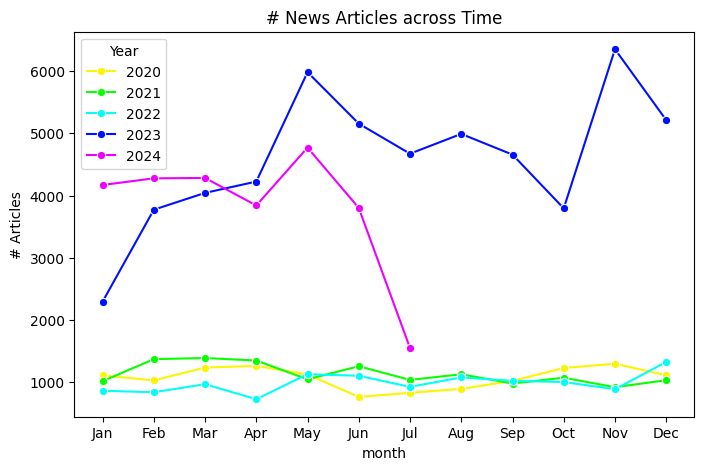

In [7]:
# Article related to AI / Data Science distribution over time

monthly_counts = news_processed.groupby(['year', 'month']).size().reset_index(name = 'count')

plt.figure(figsize=(8, 5))
palette = sns.color_palette("hsv", n_colors=monthly_counts['year'].nunique())
sns.lineplot(data=monthly_counts, x='month', y='count', hue='year', marker='o', palette=palette)
plt.ylabel('# Articles')
plt.title('# News Articles across Time')
plt.legend(title='Year')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

# We do see that volume of articles see a jump in 2023 and 2024 (with certain peaks in 2023)

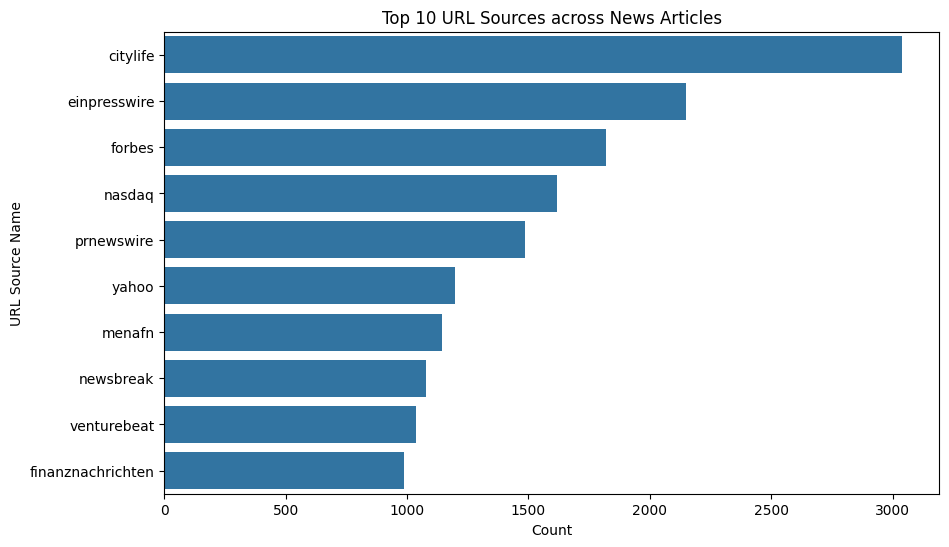

In [8]:
# What are the common news article sources (Top 10)

news_processed['url_source_name'] = news_processed['url'].str.extract(r'https?://(?:www\.)?(?:finance\.|news\.)?([^/.]+)')

url_source_name_counts = news_processed['url_source_name'].value_counts(ascending = False).reset_index(name = 'count')
url_source_top = url_source_name_counts.head(10)
url_source_top

plt.figure(figsize=(10, 6))
sns.barplot(data=url_source_top, x='count', y='url_source_name')
plt.title('Top 10 URL Sources across News Articles')
plt.xlabel('Count')
plt.ylabel('URL Source Name')
plt.show()

In [9]:
citylife_urls = news_processed[news_processed['url'].str.contains('citylife', case=False, na=False)]
citylife_urls.head(5)

# Ask: What is this citylife url?

,url,date,language,title,text,year,month,day,text_ner,title_ner,text_cleaned,title_cleaned,text_lemmatized,title_lemmatized,text_tokenized,title_tokenized,text_word_count,url_source_name
36,https://citylife.capetown/ai/digital-academy-offers-new-ai-course-to-high-school-students/346910/,2023-08-17,en,Bringing Artificial Intelligence to Schools: Embracing the Future,"\n\nBringing Artificial Intelligence to Schools: Embracing the Future\n\n\r\nSkip to content\n\nThu. Aug 17th, 2023 \n\n CityLife\nThe Power of AI Models\n \n \n \n\nAI\nDrones\nMilitary\nNews\nSatellite Telephony\nSatellite Internet\nSpace\nTechnology\nContact\n \n \n \n \n \n\n \r\n AI\r\n \n \r\n Bringing Artificial Intelligence to Schools: Embracing the Future\n\n\n \n\nByVicky Stavropoulou\n \r\...",2023,8,17,"Bringing Artificial Intelligence to Schools Embracing the Future Skip to content Thu. Aug 17th, CityLife The Power of AI Models AI Drones Military News Satellite Telephony Satellite Internet Space Technology Contact AI Bringing Artificial Intelligence to Schools Embracing the Future ByVicky Stavropoulou Aug, English, math, and science have long been the core subjects taught in schools. However, as technology continues to advance, classrooms are now offering a wider range of courses. The Mont...",Bringing Artificial Intelligence to Schools Embracing the Future,bringing artificial intelligence schools embracing future skip content thu aug citylife power ai models ai drones military news satellite telephony satellite internet space technology contact ai bringing artificial intelligence schools embracing future byvicky stavropoulou aug english math science long core subjects taught schools however technology continues advance classrooms offering wider range courses montana digital academy mtda courses students across montana aims bring artificial int...,bringing artificial intelligence schools embracing future,bringing artificial intelligence school embracing future skip content thu aug citylife power ai model ai drone military news satellite telephony satellite internet space technology contact ai bringing artificial intelligence school embracing future byvicky stavropoulou aug english math science long core subject taught school however technology continues advance classroom offering wider range course montana digital academy mtda course student across montana aim bring artificial intelligence a...,bringing artificial intelligence school embracing future,"[bringing, artificial, intelligence, school, embracing, future, skip, content, thu, aug, citylife, power, ai, model, ai, drone, military, news, satellite, telephony, satellite, internet, space, technology, contact, ai, bringing, artificial, intelligence, school, embracing, future, byvicky, stavropoulou, aug, english, math, science, long, core, subject, taught, school, however, technology, continues, advance, classroom, offering, wider, range, course, montana, digital, academy, mtda, course, ...","[bringing, artificial, intelligence, school, embracing, future]",364,citylife
37,https://citylife.capetown/ai/kuo-no-sign-of-apple-generative-ai-technology-coming-in-2024/313031/,2023-08-02,en,The Slow Progress of Apple's AI Technology,"\n\nThe Slow Progress of Apple's AI Technology\n\r\nSkip to content\n\nWed. Aug 2nd, 2023 \n\n CityLife\nThe Power of AI Models\n \n \n \n\nAI\nDrones\nMilitary\nNews\nSatellite Telephony\nSatellite Internet\nSpace\nTechnology\nContact\n \n \n \n \n \n\n \r\n AI\r\n \n \r\n The Slow Progress of Apple’s AI Technology\n\n\n \n\nByRobert Andrew\n \r\n Aug 2, 2023\n \nApple’s generat...",2023,8,2,"The Slow Progress of Apple s AI Technology Skip to content Wed. Aug 2nd, CityLife The Power of AI Models AI Drones Military News Satellite Telephony Satellite Internet Space Technology Contact AI The Slow Progress of Apple s AI Technology ByRobert Andrew Aug, Apple s generative AI technology development lags significantly behind its competitors, with no indication of plans to launch AI servi

In [10]:
einpresswire_urls = news_processed[news_processed['url'].str.contains('einpresswire', case=False, na=False)]
einpresswire_urls.head(5)

,url,date,language,title,text,year,month,day,text_ner,title_ner,text_cleaned,title_cleaned,text_lemmatized,title_lemmatized,text_tokenized,title_tokenized,text_word_count,url_source_name
371,https://www.einpresswire.com/article/528819225/axle-ai-exhibits-at-first-ever-online-adobe-max-conference-starting-today,2020-10-21,en,"axle ai exhibits at first-ever online Adobe MAX conference, starting today","\n\n axle ai exhibits at first-ever online Adobe MAX conference, starting today\n \n About\n \n About EIN Presswire\n \n How We Are Different. Better\n \n Distribution Overview\n \n How It Works\n \n Get Started\n \n Testimonials\n \n Video Tutorials\n \n Editorial Guidelines\n \n FAQs\n \n ...",2020,10,21,"axle ai exhibits at first ever online Adobe MAX conference, starting today About About EIN Presswire How We Are Different. Better Distribution Overview How It Works Get Started Testimonials Video Tutorials Editorial Guidelines FAQs Contact Pricing Distribution Pricing Comparison Chart Distribution Overview U.S. TV Radio Stations EIN Microwires Mobile Apps Press Releases All Featured By Industry By Country By US State Archive Newswires All By Industry Agriculture Airline Automotive Banking Bo...","axle ai exhibits at first ever online Adobe MAX conference, starting today",axle ai exhibits first ever online adobe max conference starting today ein presswire different better distribution overview works get started testimonials video tutorials editorial guidelines faqs contact pricing distribution pricing comparison chart distribution overview tv radio stations ein microwires mobile apps press releases featured industry country us state archive newswires industry agriculture airline automotive banking book publishing business casinos chemicals companies conferenc...,axle ai exhibits first ever online adobe max conference starting today,axle ai exhibit first ever online adobe max conference starting today ein presswire different better distribution overview work get started testimonial video tutorial editorial guideline faq contact pricing distribution pricing comparison chart distribution overview tv radio station ein microwires mobile apps press release featured industry country u state archive newswires industry agriculture airline automotive banking book publishing business casino chemical company conference trade show ...,axle ai exhibit first ever online adobe max conference starting today,"[axle, ai, exhibit, first, ever, online, adobe, max, conference, starting, today, ein, presswire, different, better, distribution, overview, work, get, started, testimonial, video, tutorial, editorial, guideline, faq, contact, pricing, distribution, pricing, comparison, chart, distribution, overview, tv, radio, station, ein, microwires, mobile, apps, press, release, featured, industry, country, u, state, archive, newswires, industry, agriculture, airline, automotive, banking, book, publishin...","[axle, ai, exhibit, first, ever, online, adobe, max, conference, starting, today]",1273,einpresswire
372,https://www.einpresswire.com/article/535152053/smarter-than-ever-segway-s-new-bot-series-uses-ai-to-make-shared-rides-safer,2021-01-30,en,Smarter Than Ever: Segway’s New Bot Series Uses AI To Make Shared Rides Safer,\n Smarter Than Ever: Segway’s New Bot Series Uses AI To Make Shared Rides Safer\n \n\n About\n \n About EIN Presswire\n \n How We Are Different. Better\n \n Distribution Overview\n \n How It Works\n \n Get Started\n \n Testimonials\n \n Video Tutorials\n \n Editorial Guidelines\n \n FAQs\n \n ...,2021,1,30,Smarter Than Ever Segway s New Bot Series Uses AI To Make Shared Rides Safer About About EIN Presswire How We Are Different. Better Distribution Overview How It Works Get Started Testimonials Video Tutorials Editorial Guidelines FAQs Contact Pricing Distribution Pricing Comparison Chart Distribution Overview U.S. TV Radio Stations EIN Microwires Mobile Apps Press Releases All Featured By Industry By Country By US State Archive News

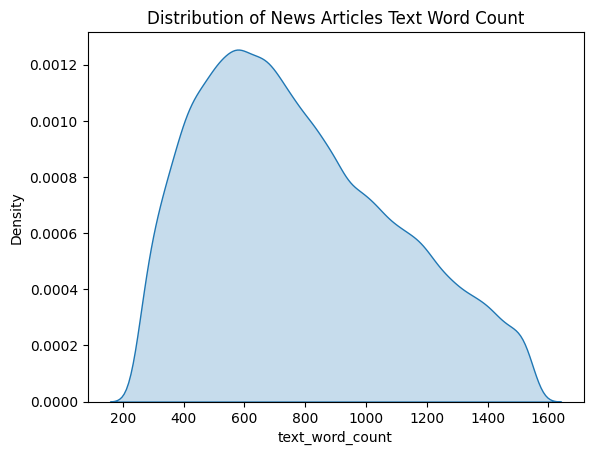

In [11]:
sns.kdeplot(news_processed['text_word_count'], shade=True)
plt.title('Distribution of News Articles Text Word Count')
plt.show()

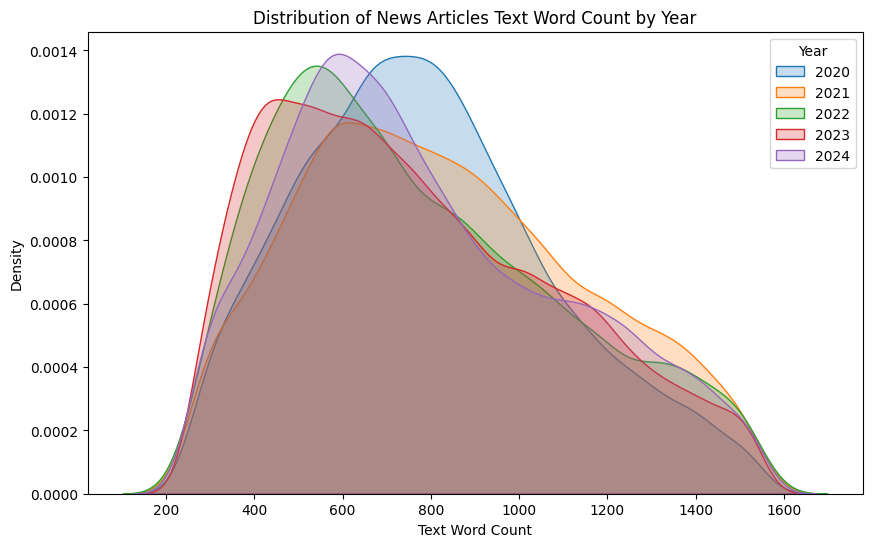

In [12]:
plt.figure(figsize=(10, 6))
for year in news_processed['year'].unique():
    subset = news_processed[news_processed['year'] == year]
    sns.kdeplot(subset['text_word_count'], shade=True, label=str(year))

plt.title('Distribution of News Articles Text Word Count by Year')
plt.xlabel('Text Word Count')
plt.ylabel('Density')
plt.legend(title='Year')
plt.show()

In [13]:
news_processed.head(5)

,url,date,language,title,text,year,month,day,text_ner,title_ner,text_cleaned,title_cleaned,text_lemmatized,title_lemmatized,text_tokenized,title_tokenized,text_word_count,url_source_name
0,http://newsparliament.com/2020/02/27/children-with-autism-saw-their-learning-and-social-skills-boosted-after-playing-with-this-ai-robot/,2020-02-27,en,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament,"\nChildren With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament\n \n\nSkip to content\n\t\t\tThursday, February 27, 2020\t\t\n\nLatest:\n\n\nMansplaining in conferences: How can we get him to forestall?\n\n\nDrax power station to cease burning coal in March 2021\n\n\nCoronavirus Could Explode in the U.S. Overnight Like it Did in Italy\n\n\nCoronavirus: Dettol sales surge as markets fall again\n\n\nLevi Strauss marks the next phase in cor...",2020,2,27,"Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot News Parliament Skip to content Thursday, February, Latest Mansplaining in conferences How can we get him to forestall Drax power station to cease burning coal in March Coronavirus Could Explode in the U.S. Overnight Like it Did in Italy Coronavirus Dettol sales surge as markets fall again Levi Strauss marks the next phase in corporate paid leave policies News Parliament Get the Real Story News...",Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot News Parliament,children autism saw learning social skills boosted playing ai robot news parliament skip content thursday february latest mansplaining conferences get forestall drax power station cease burning coal march coronavirus could explode overnight like italy coronavirus dettol sales surge markets fall levi strauss marks next phase corporate paid leave policies news parliament get real story news technology services healthcare world business entertainment world children autism saw learning social sk...,children autism saw learning social skills boosted playing ai robot news parliament,child autism saw learning social skill boosted playing ai robot news parliament skip content thursday february latest mansplaining conference get forestall drax power station cease burning coal march coronavirus could explode overnight like italy coronavirus dettol sale surge market fall levi strauss mark next phase corporate paid leave policy news parliament get real story news technology service healthcare world business entertainment world child autism saw learning social skill boosted pl...,child autism saw learning social skill boosted playing ai robot news parliament,"[child, autism, saw, learning, social, skill, boosted, playing, ai, robot, news, parliament, skip, content, thursday, february, latest, mansplaining, conference, get, forestall, drax, power, station, cease, burning, coal, march, coronavirus, could, explode, overnight, like, italy, coronavirus, dettol, sale, surge, market, fall, levi, strauss, mark, next, phase, corporate, paid, leave, policy, news, parliament, get, real, story, news, technology, service, healthcare, world, business, entertai...","[child, autism, saw, learning, social, skill, boosted, playing, ai, robot, news, parliament]",938,newsparliament
1,http://www.homeoffice.consumerelectronicsnet.com/strategy-analytics-71-of-smartphones-sold-globally-in-2021-will-be-ai-powered/,2021-03-10,en,Strategy Analytics: 71% of Smartphones Sold Globally in 2021 will be AI Powered – Consumer Electronics Net,\n\nStrategy Analytics: 71% of Smartphones Sold Globally in 2021 will be AI Powered – Consumer Electronics Net\n \nSkip to content\n\nConsumer Electronics Net\n\nPrimary Menu\n\nConsumer Electronics Net\n\nSearch for:\n \nHomeNewsStrategy Analytics: 71% of Smartphones Sold Globally in 2021 will be AI Powered \n \n News\n \n \nStrategy Analytics: 71% of Smartphones Sold Globally in

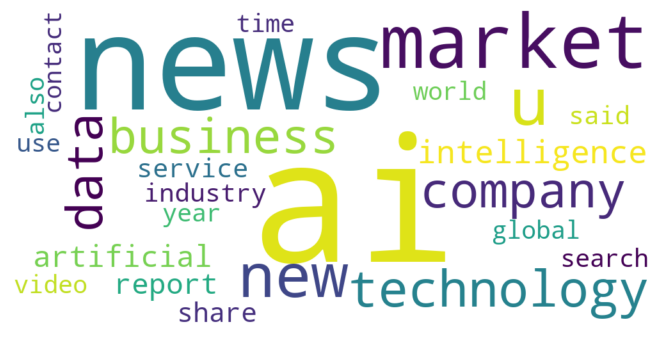

In [14]:
# Make a word cloud of the most common text tokens used in new articles
def wordCloud(list_col, count = 35):
    des_list = list_col.explode()
    ten = Counter(des_list).most_common(count)
    word, freq = zip(*ten)
    data = dict(zip(list(word),list(freq)))
    wordcloud_obj = wordcloud.WordCloud(
    width = 1000,
    height = 500,
    background_color = 'white',
    max_words = 25,
    stopwords = wordcloud.STOPWORDS)
    return wordcloud_obj.generate_from_frequencies(data)

fig = plt.figure()
figsize = (20, 10)
plt.imshow(wordCloud(news_processed['text_tokenized']), interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### 2. NER - Using SpaCy
Let's see what are the top companies, person and locations in the articles

In [15]:
%%time
from concurrent.futures import ThreadPoolExecutor

# Initialize SpaCy models
nlp_spacy = spacy.load("en_core_web_lg")

# Function to extract named entities using SpaCy
def extract_entities_spacy(text):
    doc = nlp_spacy(text, disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"])
    return [(X.label_, X.text) for X in doc.ents]

# Define a function for Batch processing
def process_batch(df, field, batch_size=100):
    batches = [df[i:i + batch_size] for i in range(0, df.shape[0], batch_size)]
    results = []
    for batch in batches:
        with ThreadPoolExecutor() as executor:
            entities = list(executor.map(extract_entities_spacy, batch[field]))
        results.extend(entities)
    return results

# Extract entities from news text separately using batch processing
news_processed['text_entities'] = process_batch(news_processed, 'text_lemmatized')

CPU times: user 1h 30min 2s, sys: 1h 44min 30s, total: 3h 14min 33s
Wall time: 54min 4s


In [16]:
# Function to get entities from specific field
def get_entities_from_field(df, field, entity_type):
    entities = Counter([item[1] for sublist in df[field] for item in sublist if item[0] == entity_type])
    return entities

news_processed_company = get_entities_from_field(news_processed, 'text_entities', 'ORG')
news_processed_person = get_entities_from_field(news_processed, 'text_entities', 'PERSON')
news_processed_location = get_entities_from_field(news_processed, 'text_entities', 'GPE')

# Display the top entities across companies, persons, locations
print("Top Companies (ORG):", news_processed_company.most_common(20))
print("")
print("Top Persons (PERSON):", news_processed_person.most_common(20))
print("")
print("Top Locations (GPE):", news_processed_location.most_common(20))

Top Companies (ORG): [('chatgpt', 133662), ('microsoft', 36822), ('gpt', 31398), ('fcc', 28233), ('ibm', 25747), ('samsung', 18747), ('google', 18019), ('android', 14714), ('npr', 13114), ('reuters', 11051), ('nvidia', 10039), ('nyse', 9802), ('cnn', 9651), ('congress', 9146), ('bestreviews', 8348), ('white house', 7760), ('etf', 7537), ('altman', 7343), ('yahoo', 7289), ('ml', 7215)]

Top Persons (PERSON): [('sam altman', 15224), ('altman', 7997), ('r gdpr', 7183), ('biden', 5833), ('joe biden', 4906), ('tom', 3574), ('baidu', 3473), ('donald trump', 3354), ('siri', 2899), ('satya nadella', 2829), ('taylor', 2695), ('cdt', 2594), ('bfsi', 2370), ('bobby allyn', 2313), ('verde cayman', 2300), ('jordan oman', 2288), ('monaco mongolia', 2285), ('rico qatar', 2150), ('deepmind', 2119), ('putin', 2114)]

Top Locations (GPE): [('india', 55048), ('china', 43696), ('japan', 22737), ('new york', 21172), ('russia', 20140), ('california', 19827), ('washington', 18649), ('israel', 17405), ('flori

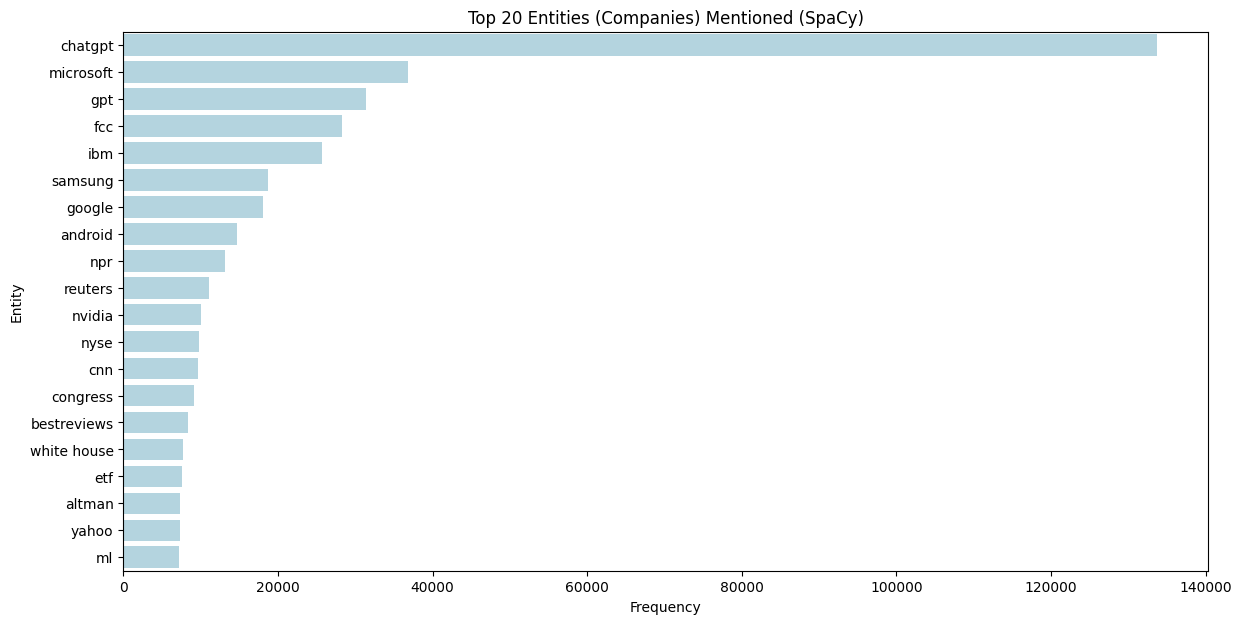

In [17]:
# Compare top 20 results for company
spacy_entity_counts_news_company = Counter(news_processed_company)
spacy_top_20_entities_news_company = spacy_entity_counts_news_company.most_common(20)
spacy_top_20_news_company_df = pd.DataFrame(spacy_top_20_entities_news_company, columns=['Entity', 'Frequency'])

# Plot top 20 entities for SpaCy (Companies mentioned in News Articles)
plt.figure(figsize=(14, 7))
sns.barplot(x='Frequency', y='Entity', data=spacy_top_20_news_company_df, color='lightblue')
plt.title('Top 20 Entities (Companies) Mentioned (SpaCy)')
plt.xlabel('Frequency')
plt.ylabel('Entity')
plt.show()

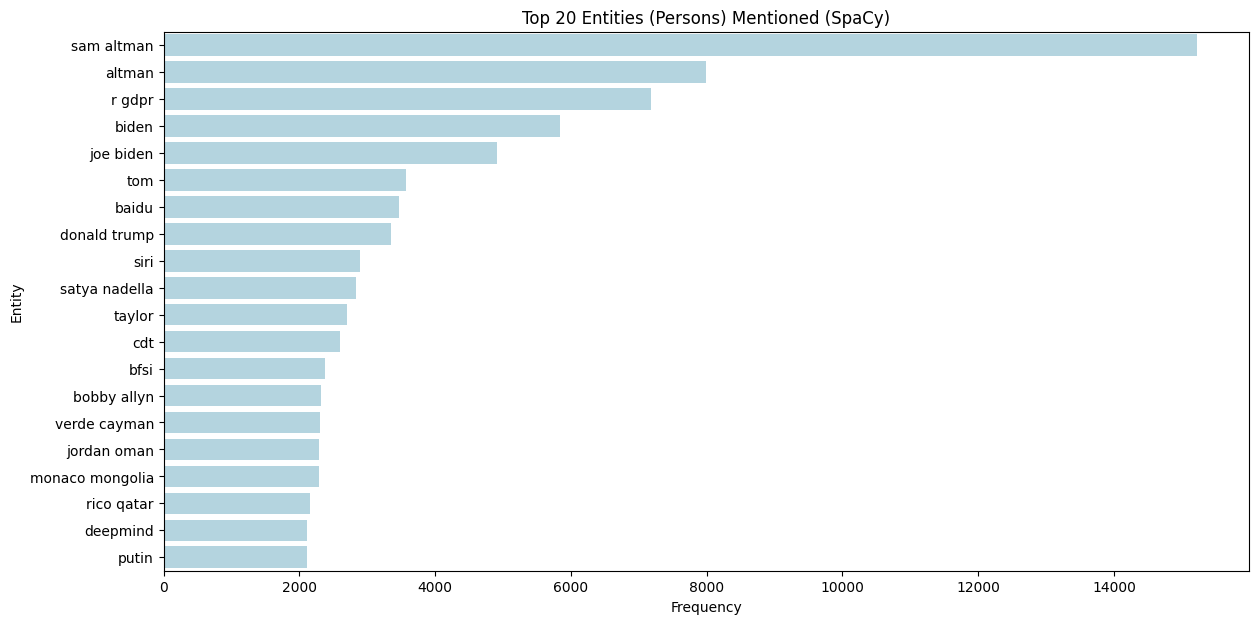

In [18]:
# Compare top 20 results for person
spacy_entity_counts_news_person = Counter(news_processed_person)
spacy_top_20_entities_news_person = spacy_entity_counts_news_person.most_common(20)
spacy_top_20_news_person_df = pd.DataFrame(spacy_top_20_entities_news_person, columns=['Entity', 'Frequency'])

# Plot top 20 entities for SpaCy (Persons mentioned in News Articles)
plt.figure(figsize=(14, 7))
sns.barplot(x='Frequency', y='Entity', data=spacy_top_20_news_person_df, color='lightblue')
plt.title('Top 20 Entities (Persons) Mentioned (SpaCy)')
plt.xlabel('Frequency')
plt.ylabel('Entity')
plt.show()

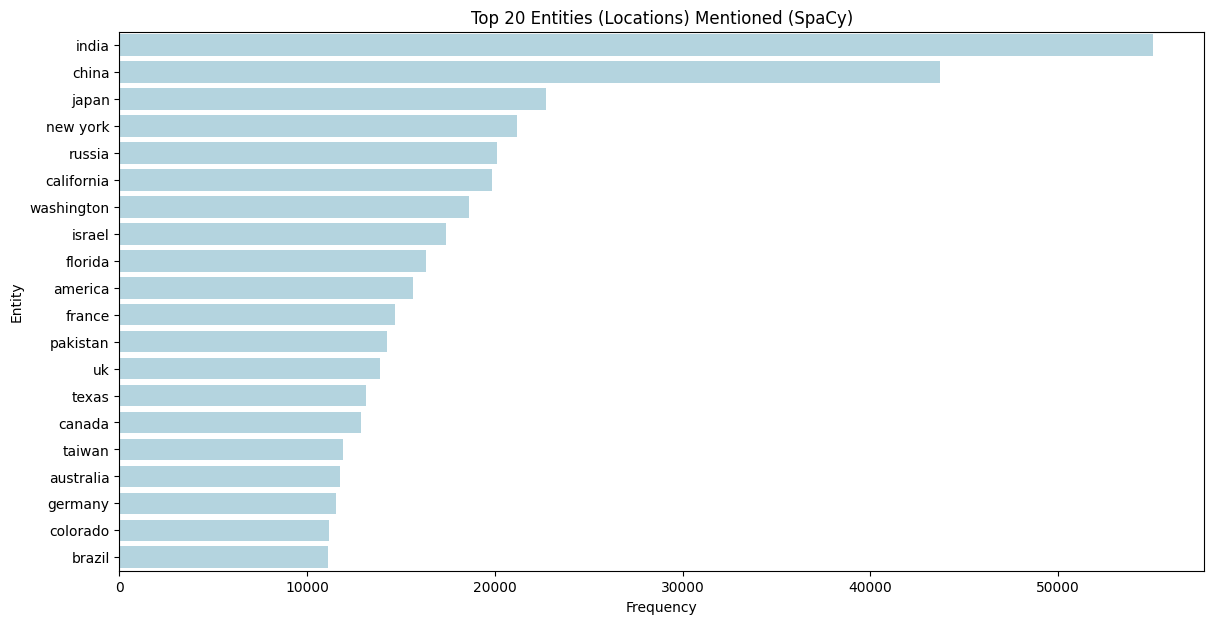

In [19]:
# Compare top 20 results for location
spacy_entity_counts_news_location = Counter(news_processed_location)
spacy_top_20_entities_news_location = spacy_entity_counts_news_location.most_common(20)
spacy_top_20_news_location_df = pd.DataFrame(spacy_top_20_entities_news_location, columns=['Entity', 'Frequency'])

# Plot top 20 entities for SpaCy (Locations mentioned in News Articles)
plt.figure(figsize=(14, 7))
sns.barplot(x='Frequency', y='Entity', data=spacy_top_20_news_location_df, color='lightblue')
plt.title('Top 20 Entities (Locations) Mentioned (SpaCy)')
plt.xlabel('Frequency')
plt.ylabel('Entity')
plt.show()

### 3. Topic Detection - Using LDA with gensim

In [20]:
# Sample 50% of data to run the LDA and use that to represent the population
news_processed = news_processed.sample(frac=0.50, random_state=123)
news_processed.shape

(60088, 19)

In [21]:
%%time
from gensim import corpora
dictionary = corpora.Dictionary(news_processed['text_tokenized'])
doc_term_matrix = [dictionary.doc2bow(doc) for doc in news_processed['text_tokenized']]
min_topics = 2
max_topics = 15
step_size = 1
topics_range = range(min_topics, max_topics+1, step_size)
num_topics = []
coherence_scores = []
model_results = {
             'Num Topics': [],
             'Topics': [],
             'Coherence Score': []
            }
itr = 0
itr_total = len(topics_range)
print(f'LDA will execute {itr_total} iterations')

# Iterate through different number of topics
for num_topics in range(min_topics, max_topics+1):

    tic()
    itr += 1
    print("Number of topics = " + str(num_topics))
    # Train the LDA model
    lda_model = LdaMulticore(corpus=doc_term_matrix,
                            id2word=dictionary,
                            num_topics=num_topics,
                            random_state=123,
                            passes=15,
                            workers=multiprocessing.cpu_count(),
                            eta='auto')

    # Compute coherence score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=news_processed['text_tokenized'], dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()

    model_results['Num Topics'].append(num_topics)
    model_results['Coherence Score'].append(coherence_score)
    topics_string = ' | '.join([str(topic) for topic in lda_model.print_topics(num_topics=num_topics)])
    model_results['Topics'].append(topics_string)

    pct_completed = round((itr / itr_total * 100),1)
    print(f'Completed model based on {num_topics} LDA topics. Finished {pct_completed}% of LDA runs')
    tac()

news_lda_model_results = pd.DataFrame(model_results)

LDA will execute 14 iterations
Number of topics = 2
Completed model based on 2 LDA topics. Finished 7.1% of LDA runs
Execution time: 0hour:7min:27sec
Number of topics = 3
Completed model based on 3 LDA topics. Finished 14.3% of LDA runs
Execution time: 0hour:7min:49sec
Number of topics = 4
Completed model based on 4 LDA topics. Finished 21.4% of LDA runs
Execution time: 0hour:8min:2sec
Number of topics = 5
Completed model based on 5 LDA topics. Finished 28.6% of LDA runs
Execution time: 0hour:8min:19sec
Number of topics = 6
Completed model based on 6 LDA topics. Finished 35.7% of LDA runs
Execution time: 0hour:8min:37sec
Number of topics = 7
Completed model based on 7 LDA topics. Finished 42.9% of LDA runs
Execution time: 0hour:9min:2sec
Number of topics = 8
Completed model based on 8 LDA topics. Finished 50.0% of LDA runs
Execution time: 0hour:9min:21sec
Number of topics = 9
Completed model based on 9 LDA topics. Finished 57.1% of LDA runs
Execution time: 0hour:9min:49sec
Number of to

<Axes: title={'center': 'Coherence Score Plot for News Articles'}, xlabel='Num Topics'>

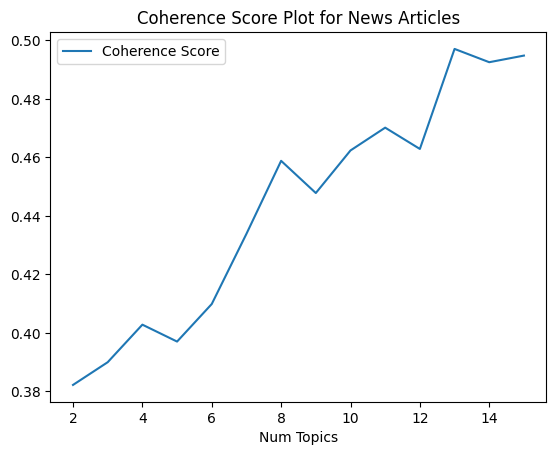

In [22]:
# Plot the coherence scores across N (number of topics)
news_lda_model_results.plot(
    x ='Num Topics', 
    y = 'Coherence Score',
    title = 'Coherence Score Plot for News Articles',
    kind = 'line')

In [23]:
# What is the right N (number of topics)?
news_lda_model_tuning_best = news_lda_model_results.sort_values(by=['Coherence Score'], ascending=False).head(1)
news_tuned_topics = int(news_lda_model_tuning_best['Num Topics'].to_string(index=False))
news_tuned_topics

13

In [24]:
def prepare_corpus(texts):
    dictionary = corpora.Dictionary(texts)
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    corpus = [dictionary.doc2bow(text) for text in texts]
    return corpus, dictionary

news_corpus, news_dictionary = prepare_corpus(news_processed['text_tokenized'])

In [25]:
%%time

news_tuned_lda_model = LdaMulticore(corpus = news_corpus,
                                    id2word = news_dictionary,
                                    num_topics = news_tuned_topics,
                                    random_state = 123,
                                    passes = 15,
                                    alpha = 'asymmetric',
                                    eta = 'auto',
                                    workers = multiprocessing.cpu_count())

CPU times: user 3min 33s, sys: 56 s, total: 4min 29s
Wall time: 5min 2s


In [26]:
print(*news_tuned_lda_model.print_topics(num_topics=news_tuned_topics, num_words=7), sep='\n\n')

(0, '0.007*"customer" + 0.005*"digital" + 0.005*"solution" + 0.005*"platform" + 0.005*"security" + 0.004*"cloud" + 0.004*"system"')

(1, '0.017*"ago" + 0.010*"hour" + 0.009*"video" + 0.007*"weather" + 0.007*"story" + 0.006*"day" + 0.006*"sport"')

(2, '0.009*"release" + 0.008*"newswires" + 0.006*"south" + 0.006*"republic" + 0.005*"ein" + 0.005*"presswire" + 0.005*"state"')

(3, '0.020*"open" + 0.013*"icon" + 0.013*"window" + 0.007*"music" + 0.005*"facebook" + 0.005*"tab" + 0.005*"tech"')

(4, '0.011*"product" + 0.009*"release" + 0.007*"consumer" + 0.007*"resource" + 0.007*"general" + 0.006*"health" + 0.006*"ment"')

(5, '0.023*"stock" + 0.019*"market" + 0.014*"nasdaq" + 0.007*"symbol" + 0.007*"investor" + 0.006*"price" + 0.005*"nvidia"')

(6, '0.015*"india" + 0.008*"price" + 0.005*"read" + 0.005*"story" + 0.004*"indian" + 0.004*"tech" + 0.004*"subscribe"')

(7, '0.006*"chatgpt" + 0.005*"openai" + 0.004*"people" + 0.004*"say" + 0.003*"could" + 0.003*"would" + 0.003*"human"')

(8, '0.010

In [27]:
lda_display = gensimvis.prepare(news_tuned_lda_model, 
                                news_corpus, 
                                news_dictionary, 
                                sort_topics=False, 
                                mds='mmds', 
                                n_jobs=1)
pyLDAvis.display(lda_display)

### For news article data (sampled at 50%), N = 13 topics are picked based on the coherence score. The topics likley are:
1. Related to cloud platform, customer solution and digital security
(There is a lot of focus on cybersecurity and AI, along with cloud intergration with AI)
https://www.forbes.com/sites/forbestechcouncil/2024/02/15/ai-in-cybersecurity-revolutionizing-safety/

2. Related to time (ago, hour), weather, top story, video
3. Related to region, month and releases

4. Related to open window, open tab, icon, facebook, music, linkedin
(AI will also influence how we interact with social media, content like music)
https://www.forbes.com/sites/kalinabryant/2024/03/14/how-ai-is-reshaping-social-media-platforms-and-5-tips-for-success/
https://time.com/6340294/ai-transform-music-2023/

5. Related to product release, general health, energy, transportation, travel
(AI will influence industry like energy as training models and running them has high usage of energy and requires a huge ramp in energy infrastructure and there is an ever increasing risk to climate change, health positively and help increase effective transportation and travel)
https://www.nytimes.com/2024/07/11/climate/artificial-intelligence-energy-usage.html
https://www.npr.org/2024/07/12/g-s1-9545/ai-brings-soaring-emissions-for-google-and-microsoft-a-major-contributor-to-climate-change
https://www.forbes.com/sites/forbestechcouncil/2024/01/18/the-role-of-ai-in-healthcare/
https://www.forbes.com/sites/timothypapandreou/2024/03/04/generative-ai-is-coming-to-the-transportation-industry-is-it-ready/

6. Related to stock market, nasdaq, nvidia, price, earnings, chip
(AI has help boost nvidia to record highs at 3 trillion market cap at one point, chip industry will see a lot of investment and growth)
https://www.nytimes.com/2024/03/15/business/nvidia-stock-market-ai-bubble.html
https://www.cnbc.com/2024/04/16/amd-launches-new-chips-for-ai-pcs-amid-fierce-fight-with-nvidia-intel.html

7. Related to india, tech in india, election, delhi election, bank
(AI has seen investment from govt but increased scrunity too and has seen an effect on elections too (deepfakes, misinformation). Banks have invested in chatbots for support and fraud detection)
https://www.newindianexpress.com/xplore/2024/May/17/future-of-indian-banking-is-intelligent-secure-and-driven-by-ai#:~:text=personalising%20customer%20experiences.-,Studies%20indicate%20that%20a%20large%20section%20of%20Indian%20banks%20leverage,secure%2C%20and%20driven%20by%20AI.
https://www.weforum.org/agenda/2024/08/deepfakes-india-tackling-ai-generated-misinformation-elections/
https://techcrunch.com/2024/03/03/india-reverses-ai-stance-requires-government-approval-for-model-launches/

8. Related to openai, chatgpt, people say would/could change human job, tool
(AI and rise of chatgpt has definitely helped humans and made certain job easier / more productive but it also risks destablizing certain jobs and cause layoffs, there seems to be a lot of articles discussing chatgpt and its impact on job market)

9. Related to health insurance, patient, medical care, cancer, submit photo
(AI will make health care process faster but at the same time can wrongfully deny claims due to biases and there can be regulation around that. AI will help detect cancer faster)
https://www.axios.com/2024/01/02/ai-health-care-insurance-tools-medicare
https://www.cbsnews.com/news/health-insurance-humana-united-health-ai-algorithm/

10. Related to public radio, npr, program schedule, podcasts, local board
(AI has sprout up a lot of radio and podcast debate as well as local discussions around its effect and future)

11. Related to learning, science, model, research, university
https://www.wsj.com/articles/universities-dont-want-ai-research-to-leave-them-behind-20318395

12. Related to google, best user feature, apple, tech review, mobile
(AI and Google have deep interlinks but caught off guard by chatgpt they have been ramping up AI efforts and comptetition among mega caps have reached an all time high)

13. Related to market, global, growth analysis, research, forecast
(AI is in nascent stage and a lot is dependent on forecast and growth analysis with different markets reacting differently and stepping up)
